In [ ]:
!pip install mediapipe opencv-python-headless
!apt-get install ffmpeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found ex

^C


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving IMG_5858.MOV to IMG_5858.MOV


In [ ]:
!ffmpeg -i IMG_5858.MOV -vcodec libx264 output.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

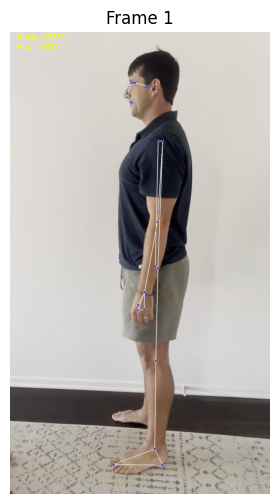

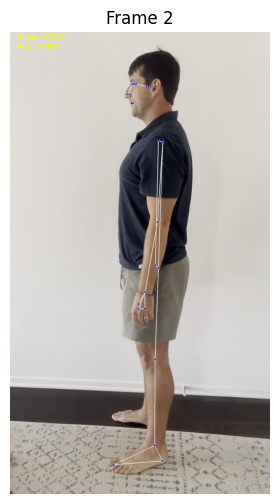

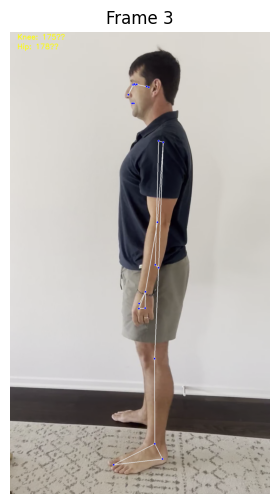

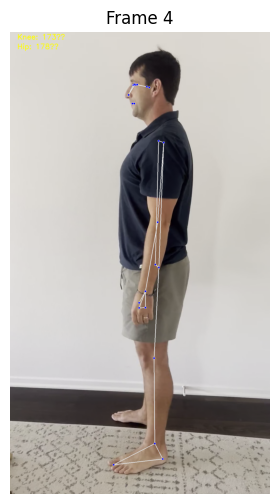

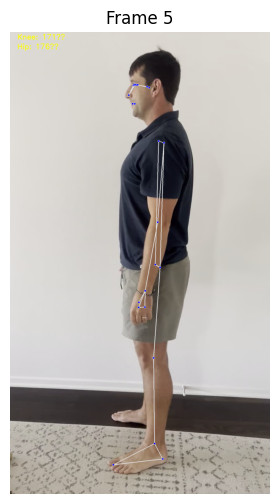

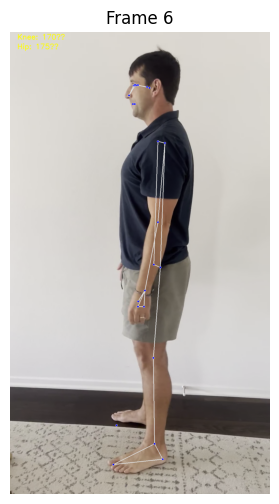

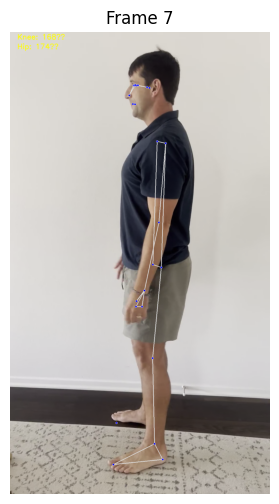

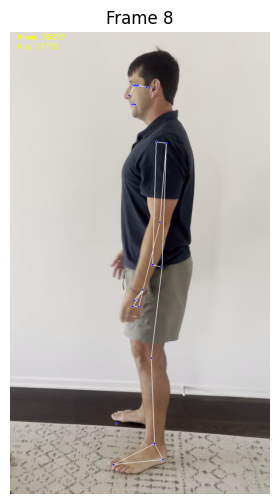

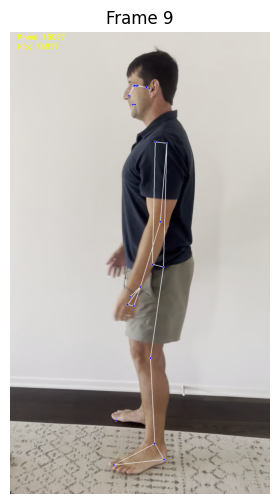

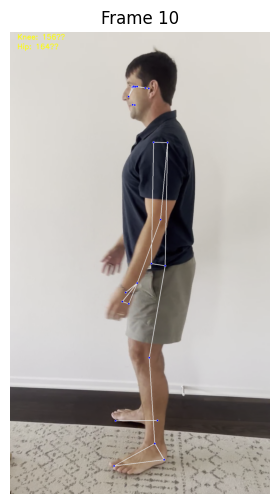

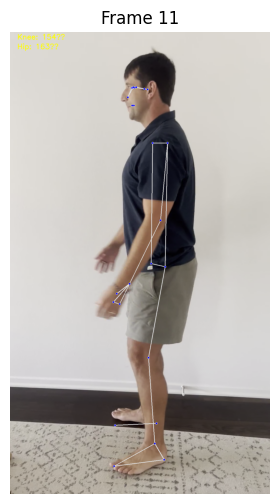

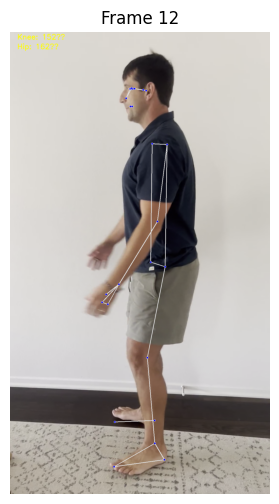

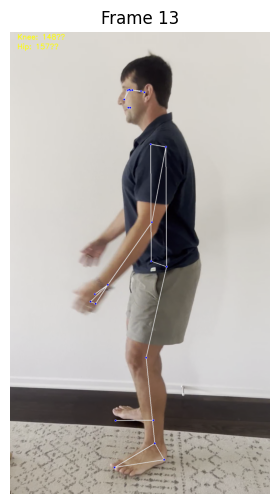

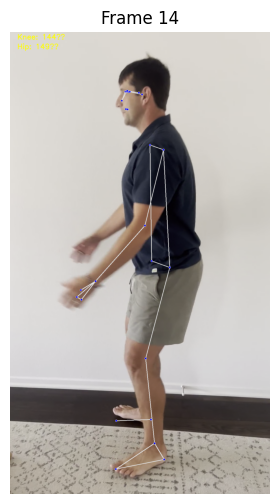

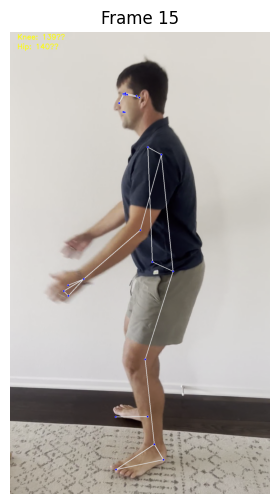

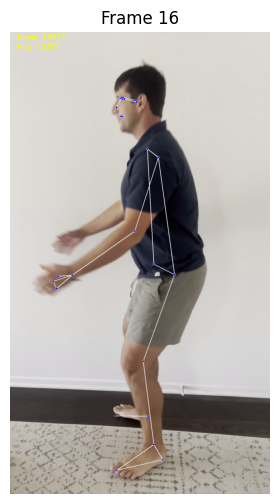

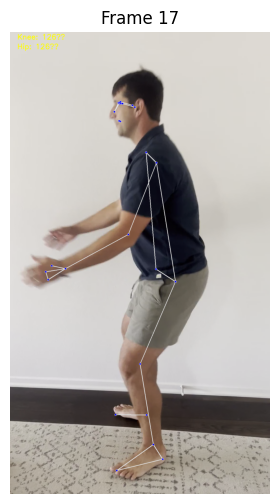

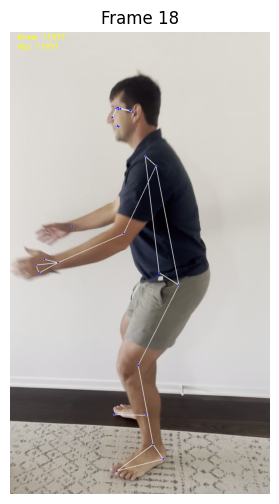

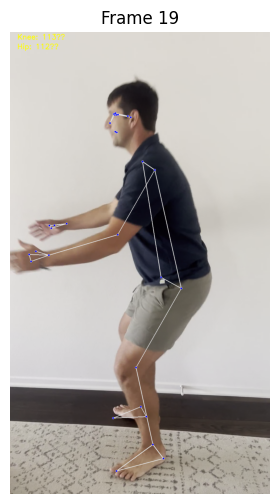

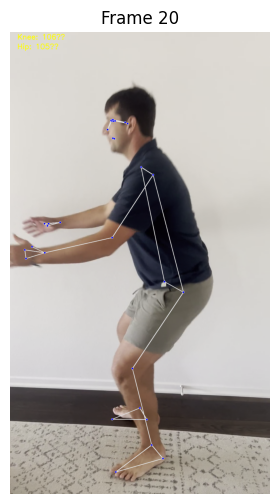

✅ Total frames processed: 218
✅ Frames with pose detected: 218


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Helper function to calculate joint angle
def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    radians = np.arccos(np.clip(np.dot(a - b, c - b) /
                                (np.linalg.norm(a - b) * np.linalg.norm(c - b)), -1.0, 1.0))
    return np.degrees(radians)

# Initialize video and storage lists
cap = cv2.VideoCapture("output.mp4")
knee_angles = []
hip_angles = []
frame_numbers = []
pose_detected = 0
max_frames_to_show = 20

with mp_pose.Pose(static_image_mode=False,
                  min_detection_confidence=0.5,
                  min_tracking_confidence=0.5) as pose:

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1

        # Convert to RGB for MediaPipe
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        if results.pose_landmarks:
            pose_detected += 1
            landmarks = results.pose_landmarks.landmark

            try:
                # Extract 2D joint locations
                shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
                knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
                ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

                # Calculate joint angles
                knee_angle = calculate_angle(hip, knee, ankle)
                hip_angle = calculate_angle(shoulder, hip, knee)

                knee_angles.append(knee_angle)
                hip_angles.append(hip_angle)
                frame_numbers.append(frame_idx)

                # Annotate and show first N frames
                annotated = image.copy()
                cv2.putText(annotated, f'Knee: {int(knee_angle)}°', (30, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
                cv2.putText(annotated, f'Hip: {int(hip_angle)}°', (30, 70),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
                mp_drawing.draw_landmarks(annotated, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

                if len(knee_angles) <= max_frames_to_show:
                    plt.figure(figsize=(8, 6))
                    plt.imshow(annotated)
                    plt.axis('off')
                    plt.title(f'Frame {frame_idx}')
                    plt.show()

            except Exception as e:
                print("Landmark error:", e)
                continue

cap.release()
print(f"✅ Total frames processed: {frame_idx}")
print(f"✅ Frames with pose detected: {pose_detected}")


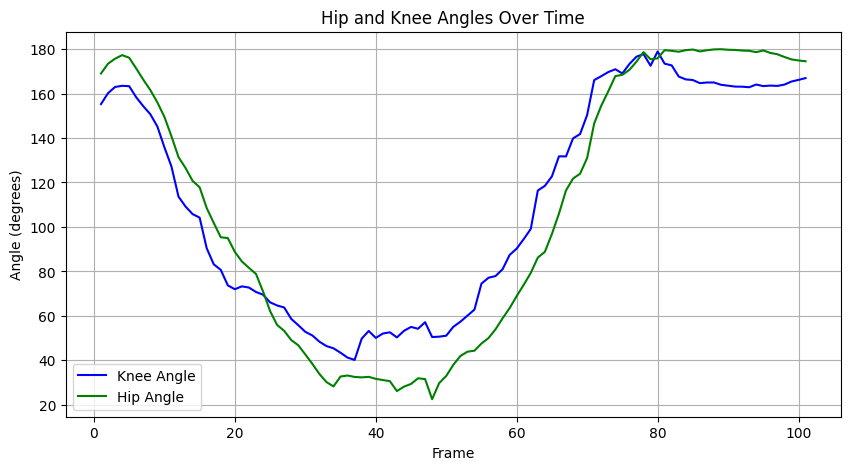

In [ ]:
if len(knee_angles) == 0 or len(hip_angles) == 0:
    print("No valid angles detected.")
else:
    plt.figure(figsize=(10, 5))
    plt.plot(frame_numbers, knee_angles, label="Knee Angle", color='blue')
    plt.plot(frame_numbers, hip_angles, label="Hip Angle", color='green')
    plt.xlabel("Frame")
    plt.ylabel("Angle (degrees)")
    plt.title("Hip and Knee Angles Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()


Minimum angles — Hip: 22.5°, Knee: 40.2°
Maximum angles — Hip: 179.9°, Knee: 178.9°


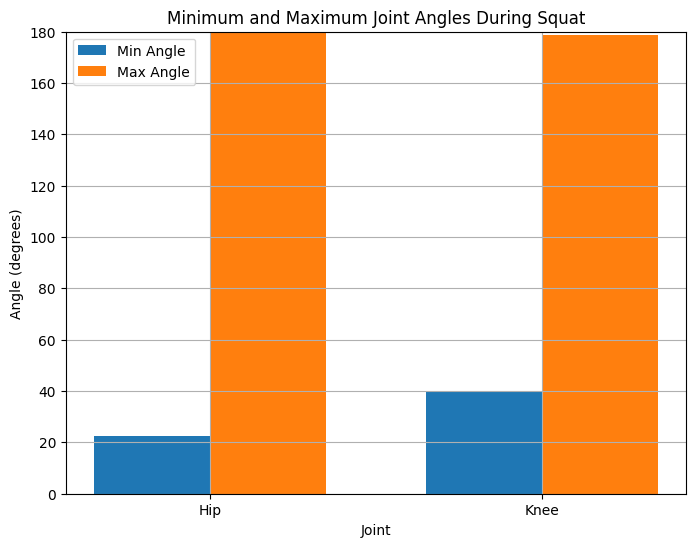

In [ ]:
if len(knee_angles) > 0 and len(hip_angles) > 0:
    joints = ['Hip', 'Knee']
    min_angles = [np.min(hip_angles), np.min(knee_angles)]
    max_angles = [np.max(hip_angles), np.max(knee_angles)]

    print(f"Minimum angles — Hip: {min_angles[0]:.1f}°, Knee: {min_angles[1]:.1f}°")
    print(f"Maximum angles — Hip: {max_angles[0]:.1f}°, Knee: {max_angles[1]:.1f}°")

    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.35
    x = np.arange(len(joints))

    ax.bar(x - bar_width/2, min_angles, width=bar_width, label='Min Angle')
    ax.bar(x + bar_width/2, max_angles, width=bar_width, label='Max Angle')

    ax.set_xlabel('Joint')
    ax.set_ylabel('Angle (degrees)')
    ax.set_title('Minimum and Maximum Joint Angles During Squat')
    ax.set_xticks(x)
    ax.set_xticklabels(joints)
    ax.legend()
    plt.ylim(0, 180)
    plt.grid(True)
    plt.show()


In [ ]:
# Thresholds for detecting squat motion
min_flexion_threshold = 90   # Below this = bottom of squat
max_extension_threshold = 160 # Above this = standing

reps = []
in_rep = False

for i in range(1, len(knee_angles)):
    angle = knee_angles[i]

    if not in_rep and angle < min_flexion_threshold:
        in_rep = True  # Begin descent

    elif in_rep and angle > max_extension_threshold:
        reps.append(frame_numbers[i])
        in_rep = False  # Rep complete

print(f"✅ Total reps detected: {len(reps)}")
print(f"📍 Rep frames: {reps}")


✅ Total reps detected: 1
📍 Rep frames: [71]
